In [1]:
"""
This implementation is for basic "anchor-based object detection learner", so not optimized
"""
0

0

In [2]:
import random, math, time, os, glob, re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch.optim as optim
import visualization as vis
#vis.show?

In [3]:
class MyDataset(Dataset):
    def __init__(self, imgPathL, antPathL, classL):
        self.imgPathL = imgPathL
        self.antPathL = antPathL
        self.classL   = classL
        assert len(self.imgPathL)==len(self.antPathL)
    
    def __len__(self):
        return len(self.imgPathL)
    
    def __getitem__(self, index):
        img   = cv2.imread( self.imgPathL[index] )/255
        rawShape = torch.Tensor( img.shape[:-1] )
        img   = cv2.resize( img, (224,224) )
        img   = torch.Tensor(img).permute(2,0,1)
        #
        xml   = open(self.antPathL[index],"r").read()
        catL  = re.findall("<name>(.*)</name>", xml)
        xminL = re.findall("<xmin>(.*)</xmin>", xml)
        yminL = re.findall("<ymin>(.*)</ymin>", xml)
        xmaxL = re.findall("<xmax>(.*)</xmax>", xml)
        ymaxL = re.findall("<ymax>(.*)</ymax>", xml)
        L = [] # flaot voc
        
        "gt belong"
        belongB = [  ] # (B,28,28,2,5)
        
        for i in range(10):
            if i<len(catL):
                xmin, ymin = int(xminL[i])/rawShape[1], int(yminL[i])/rawShape[0]
                xmax, ymax = int(xmaxL[i])/rawShape[1], int(ymaxL[i])/rawShape[0]
                L.append( [self.classL.index(catL[i]), xmin, ymin, xmax, ymax] )
            else:
                L.append( [-1,0,0,0,0] )
        ant = torch.Tensor(L)
        return img, ant, rawShape

trainImgPathL = sorted(glob.glob("./archive/train_zip/train/*.jpg"))
trainAntPathL = sorted(glob.glob("./archive/train_zip/train/*.xml"))
validImgPathL = sorted(glob.glob("./archive/test_zip/test/*.jpg"))
validAntPathL = sorted(glob.glob("./archive/test_zip/test/*.xml"))
trainDataset  = MyDataset(trainImgPathL, trainAntPathL, ["apple","banana","orange"])
validDataset  = MyDataset(validImgPathL, validAntPathL, ["apple","banana","orange"])

print( len(trainDataset), len(validDataset) )
img, ant, rawShape = trainDataset[0]
print( img.shape, ant.shape )

240 60
torch.Size([3, 224, 224]) torch.Size([10, 5])


In [4]:
trainDataLoader = DataLoader(trainDataset, batch_size=16, pin_memory=False)
validDataLoader = DataLoader(validDataset, batch_size=16, pin_memory=False)
print( len(trainDataLoader), len(validDataLoader) ) # 240/16=15 # 60/16=4

15 4


In [5]:
cats = 3
anchors = [(1.000,1.000), (0.666,1.333), (1.333,0.666),\
           (2.000,2.000), (1.333,2.666), (2.666,1.333),\
           (4.000,4.000), (2.666,5.333), (5.333,2.666),]

class MyModel(nn.Module):
    def __init__(self, cats, anchors):
        super().__init__()
        self.conv1   = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu1   = nn.ReLU()
        self.maxpool1= nn.MaxPool2d(2)
        self.conv2   = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu2   = nn.ReLU()
        self.maxpool2= nn.MaxPool2d(2)
        self.conv3   = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu3   = nn.ReLU()
        self.maxpool3= nn.MaxPool2d(2)
        outC         = (cats+1+4)*len(anchors)
        self.conv4   = nn.Conv2d(in_channels=64, out_channels=outC, kernel_size=3, stride=1, padding=1)
    def forward(self, x): # (bz,3,224,224)
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x) # (bz,64,112,112) # x2
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x) # (bz,64,56,56) # x4
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.maxpool3(x) # (bz,64,28,28) # x8
        x = self.conv4(x)
        return x

model = MyModel(cats, anchors)
for img, ant, rawShape in trainDataLoader:
    out = model( img )
    print( out.shape, ant.shape, rawShape.shape )
    break
# 72=8*9 # 8: (cls0,cls1,cls2,clsB,cx,cy,w,h)

torch.Size([16, 72, 28, 28]) torch.Size([16, 10, 5]) torch.Size([16, 2])


In [89]:
# 1 optimize loss speed
# 2 training code

def iou(boxA, boxB): # VOC
    (xminA, yminA, xmaxA, ymaxA), (xminB, yminB, xmaxB, ymaxB) = boxA, boxB
    inter = max(0,min(ymaxA,ymaxB)-max(yminA,yminB)) * max(0,min(xmaxA,xmaxB)-max(xminA,xminB))
    areaA = (ymaxA-yminA) * (xmaxA-xminA)
    areaB = (ymaxB-yminB) * (xmaxB-xminB)
    return inter / (areaA+areaB-inter) if (areaA+areaB-inter)!=0 else 0

iouL = []
# 1/cat * Sigma cls (cross entropy) + 10/anchors * Sigma reg (yolov1 coordinates loss)
class MyLoss(nn.Module):
    def __init__(self, cats, anchors):
        super().__init__()
        self.cats    = cats
        self.anchors = anchors
        self.ce      = nn.CrossEntropyLoss()
        self.na      = 28*28*len(anchors)
    
    def forward(self, yPredB, yTrueB): # (16,72,28,28), (16,10,5) # 40 secs # loss=220k
        "gt belong"
        belongB = [  ] # (B,28,28,2,5)
        for yTrue in yTrueB:
            labels = yTrue[ yTrue[:,0]>-1 ]
            for x,y in zip(labels[:,1], labels[:,2]):
                print(x,y)
        return                        
        
        loss = 0
        BLoss, CLoss = 0,0
        R    = torch.Tensor(list(range(28)))/28
        BG   = torch.Tensor([cats]).type(torch.int64)
        pos, mid, neg = 0, 0, 0
        
        
        #for yPred,yTrue in zip(yPredB,yTrueB): # iterate over batches # (72=8*9,28,28), (10,5), (2,)
        
        for a,(ah,aw) in enumerate(self.anchors): # iterate over anchor sizes
            scaleAnchors = yPredB[:,a*(self.cats+5):(a+1)*(self.cats+5),:,:] # (B,8,28,28)
            "classification"
            c = scaleAnchors[:,:self.cats+1,:,:] # (B,c+1,28,28)
            c = torch.softmax(c, axis=1).permute(0,2,3,1).flatten(1,2) # (B,784,c+1)
            
            "regression: convert to yolo with anchors"
            r  = scaleAnchors[:,self.cats+1:,:,:] # (B,4,28,28)
            cx = r[:,0,:,:] + R # add along axis 0 recursively # (B,28,28)+(28,) = (B,28,28)
            cy = r[:,0,:,:] + R # (B,28,28)
            w  = (torch.abs(r[:,2,:,:])+1/28)*aw # (B,28,28)
            h  = (torch.abs(r[:,3,:,:])+1/28)*ah # (B,28,28)
            xmin = (cx-w/2).flatten() # (B,784)
            ymin = (cy-h/2).flatten() # (B,784)
            xmax = (cx+w/2).flatten() # (B,784)
            ymax = (cy+h/2).flatten() # (B,784)
            w  = w.flatten()
            h  = h.flatten()
            
            "compute loss"
            for i,yTrue in enumerate(yTrueB): # (10,5)
                D
            
            
            if False:                
                "compute loss"
                yTrue = yTrue[ yTrue[:,0]>-1 ]
                for gtc, gtxmin, gtymin, gtxmax, gtymax in yTrue:
                    for i in range(784):
                        iou_val = iou( (gtxmin, gtymin, gtxmax, gtymax), (xmin[i], ymin[i], xmax[i], ymax[i]) )
                        iouL.append(iou_val)
                        if iou_val>=0.7:
                            pos+=1; #continue
                            gtw, gth = gtxmax-gtxmin, gtymax-gtymin
                            boxLoss  = (gtxmax-xmin[i])**2 +(gtymin-ymin[i])**2 +(gtw**0.5-w[i]**0.5)**2 +(gth**0.5-h[i]**0.5)**2
                            catLoss  = self.ce(c[i:i+1,:], torch.Tensor([gtc]).type(torch.int64) )
                            #print(boxLoss, catLoss)
                        elif iou_val<0.3:
                            if random.random()>0.0001: # balance
                                continue
                            neg+=1; #continue
                            boxLoss  = 0
                            catLoss  = self.ce(c[i:i+1,:], BG )
                        else:
                            mid+=1; continue
                        BLoss+=1000*10/self.na*boxLoss / (pos) if pos!=0 else 0
                        CLoss+=catLoss / (pos+neg)
                        loss += BLoss + CLoss
                #break
            #break
            print("anchors", pos, mid, neg)
            #break
            #print("A")
        return loss, BLoss, CLoss
    
#     def forward(self, yPredB, yTrueB): # (16,72,28,28), (16,10,5) # 40 secs # loss=220k
#         loss = 0
#         BLoss, CLoss = 0,0
#         R    = torch.Tensor(list(range(28)))/28
#         BG   = torch.Tensor([cats]).type(torch.int64)
#         pos, mid, neg = 0, 0, 0
#         for yPred,yTrue in zip(yPredB,yTrueB): # iterate over batches # (24,28,28), (10,5), (2,)
#             for a,(ah,aw) in enumerate(self.anchors): # iterate over anchor sizes
#                 scaleAnchors = yPred[a*(self.cats+5):(a+1)*(self.cats+5)] # (8,28,28)
#                 c = scaleAnchors[:self.cats+1,:,:] # (c+1,28,28)
#                 c = torch.softmax(c, axis=0).permute(1,2,0).flatten(0,1) # (784,c+1)
                
#                 "convert to yolo with anchors"
#                 r = scaleAnchors[self.cats+1:,:,:] # ((cx,cy,w,h),28,28)
#                 cx = r[0,:,:] + R # add alog axis 0 by default # (28,28)+(28,)=(28,28)
#                 cy = r[1,:,:] + R # (28,28)
#                 w  = (torch.abs(r[2,:,:])+1/28)*aw # (28,28)
#                 h  = (torch.abs(r[3,:,:])+1/28)*ah # (28,28)
#                 xmin = (cx-w/2).flatten() # (784,)
#                 ymin = (cy-h/2).flatten() # (784,)
#                 xmax = (cx+w/2).flatten() # (784,)
#                 ymax = (cy+h/2).flatten() # (784,)
#                 w  = w.flatten()
#                 h  = h.flatten()
                
#                 "compute loss"
#                 yTrue = yTrue[ yTrue[:,0]>-1 ]
#                 for gtc, gtxmin, gtymin, gtxmax, gtymax in yTrue:
#                     for i in range(784):
#                         iou_val = iou( (gtxmin, gtymin, gtxmax, gtymax), (xmin[i], ymin[i], xmax[i], ymax[i]) )
#                         iouL.append(iou_val)
#                         if iou_val>=0.7:
#                             pos+=1; #continue
#                             gtw, gth = gtxmax-gtxmin, gtymax-gtymin
#                             boxLoss  = (gtxmax-xmin[i])**2 +(gtymin-ymin[i])**2 +(gtw**0.5-w[i]**0.5)**2 +(gth**0.5-h[i]**0.5)**2
#                             catLoss  = self.ce(c[i:i+1,:], torch.Tensor([gtc]).type(torch.int64) )
#                             #print(boxLoss, catLoss)
#                         elif iou_val<0.3:
#                             if random.random()>0.0001: # balance
#                                 continue
#                             neg+=1; #continue
#                             boxLoss  = 0
#                             catLoss  = self.ce(c[i:i+1,:], BG )
#                         else:
#                             mid+=1; continue
#                         BLoss+=1000*10/self.na*boxLoss / (pos) if pos!=0 else 0
#                         CLoss+=catLoss / (pos+neg)
#                         loss += BLoss + CLoss
#                 #break
#             #break
#             print("anchors", pos, mid, neg)
#             #break
#             #print("A")
#         return loss, BLoss, CLoss
    
#     def forwardx(self, yPredB, yTrueB): # 68 secs, loss=220k
#         loss = 0
#         #pos, mid, neg = 0, 0, 0
#         for yPred,yTrue in zip(yPredB,yTrueB): # iterate over batches # (24,28,28), (10,5), (2,)
#             for a,(ah,aw) in enumerate(self.anchors): # iterate over anchor sizes
#                 scaleAnchors = yPred[a*(self.cats+5):(a+1)*(self.cats+5)] # (8,28,28)
#                 for i in range(scaleAnchors.shape[1]): # iterate over grids
#                     for j in range(scaleAnchors.shape[2]):
#                         vec  = scaleAnchors[:,i,j] # (8,)
#                         c    = vec[:self.cats+1] # cls0,cls1,cls2,clsB
#                         c    = torch.softmax(c,axis=0).unsqueeze(0) # (1,4)
#                         dcx, dcy, dw, dh = vec[self.cats+1:] # yolo grid
#                         #print(dcx, dcy, dw, dh)
                        
#                         "convert to yolo with anchors"
#                         cx,     cy,    w,    h = j/28+dcx, i/28+dcy, (abs(dw)+1/28)*aw, (abs(dh)+1/28)*ah
#                         xmin, ymin, xmax, ymax = (cx-w/2), (cy-h/2), (cx+w/2), (cy+h/2)
#                         # print(a, i, j, [ round(float(e),4) if type(e)!=str else "|" for e in [cx,cy,w,h,"|",xmin,ymin,xmax,ymax] ] )
#                         # continue
                        
#                         "compute loss"
#                         yTrue = yTrue[ yTrue[:,0]>-1 ]
#                         for cid, gtxmin, gtymin, gtxmax, gtymax in yTrue:
#                             iou_val = iou( (gtxmin, gtymin, gtxmax, gtymax), (xmin, ymin, xmax, ymax) )
#                             #iouL.append(iou_val)
#                             if iou_val>=0.7:
#                                 #pos+=1; continue
#                                 gtw, gth = gtxmax-gtxmin, gtymax-gtymin
#                                 boxLoss  = (gtxmax-xmin)**2 +(gtymin-ymin)**2 +(gtw**0.5-w**0.5)**2 +(gth**0.5-h**0.5)**2
#                                 catLoss  = self.ce( c, torch.Tensor([cid]).type(torch.int64) )
#                                 #print(boxLoss, catLoss)
#                             elif iou_val<0.3:
#                                 #neg+=1; continue
#                                 boxLoss  = 0
#                                 catLoss  = self.ce( c, torch.Tensor([cats]).type(torch.int64) )
#                             else:
#                                 #mid+=1
#                                 continue
#                             loss += catLoss + 10/self.na*boxLoss
#                 #break
#             #break
#             #print(pos, mid, neg)
#             #break
#             print("A")
#         return loss

In [90]:
ant[7]

tensor([[ 0.0000,  0.0420,  0.1467,  0.8108,  1.0000],
        [-1.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [-1.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [-1.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [-1.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [-1.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [-1.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [-1.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [-1.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [-1.0000,  0.0000,  0.0000,  0.0000,  0.0000]])

In [91]:
import time
lossFunc = MyLoss(cats, anchors)
s = time.time()
print(lossFunc(out, ant))
print(time.time()-s) # 65 sec

tensor(0.0229) tensor(0.0430)
tensor(0.0373) tensor(0.0660)
tensor(0.3267) tensor(0.0757)
tensor(0.0015) tensor(0.0688)
tensor(0.1779) tensor(0.0115)
tensor(0.0956) tensor(0.0491)
tensor(0.5188) tensor(0.3262)
tensor(0.1312) tensor(0.5325)
tensor(0.2425) tensor(0.3625)
tensor(0.3313) tensor(0.2281)
tensor(0.4593) tensor(0.3480)
tensor(0.0420) tensor(0.1467)
tensor(0.1614) tensor(0.3225)
tensor(0.2361) tensor(0.2969)
tensor(0.0987) tensor(0.0967)
tensor(0.1480) tensor(0.2080)
tensor(0.0460) tensor(0.1100)
tensor(0.1516) tensor(0.2981)
tensor(0.4906) tensor(0.2629)
tensor(0.1962) tensor(0.2872)
tensor(0.2940) tensor(0.4360)
tensor(0.1980) tensor(0.2620)
tensor(0.4700) tensor(0.2840)
None
0.010008573532104492


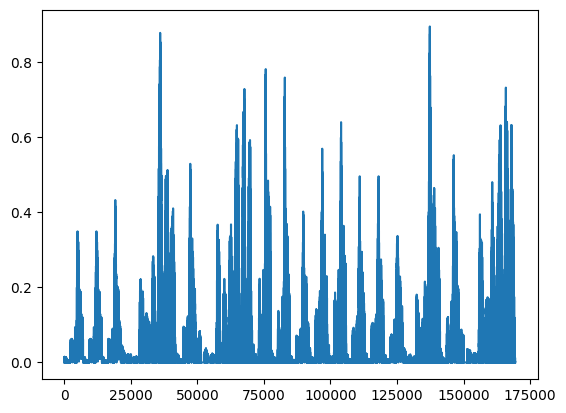

In [86]:
plt.plot( [ float(x) for x in iouL ] )
plt.show() # all anchors iou

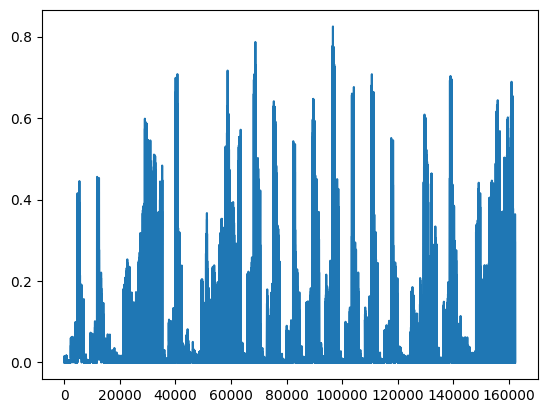

32


In [154]:
plt.plot( [ float(x) for x in iouL ] )
plt.show() # all anchors iou
print( len([ float(x) for x in iouL if float(x)>0.7 ]) )

In [101]:
torch.Tensor([[1,2],[3,4]]) + torch.Tensor([100,200])

tensor([[101., 202.],
        [103., 204.]])

In [133]:
T = torch.randn(2,3,4)
print( T )
print( T.flatten(start_dim=0,end_dim=1) )
print( T.flatten(start_dim=1,end_dim=2) )

tensor([[[-1.3014,  0.1270, -1.2077,  0.3704],
         [ 1.7506,  0.4490, -1.3556, -0.6020],
         [ 0.2827,  0.0272, -0.4709, -0.4173]],

        [[-0.0126,  0.7924,  0.2863,  0.4084],
         [ 1.0585,  0.4490,  0.5997, -1.3732],
         [-0.9512, -0.0773,  0.8045,  0.0669]]])
tensor([[-1.3014,  0.1270, -1.2077,  0.3704],
        [ 1.7506,  0.4490, -1.3556, -0.6020],
        [ 0.2827,  0.0272, -0.4709, -0.4173],
        [-0.0126,  0.7924,  0.2863,  0.4084],
        [ 1.0585,  0.4490,  0.5997, -1.3732],
        [-0.9512, -0.0773,  0.8045,  0.0669]])
tensor([[-1.3014,  0.1270, -1.2077,  0.3704,  1.7506,  0.4490, -1.3556, -0.6020,
          0.2827,  0.0272, -0.4709, -0.4173],
        [-0.0126,  0.7924,  0.2863,  0.4084,  1.0585,  0.4490,  0.5997, -1.3732,
         -0.9512, -0.0773,  0.8045,  0.0669]])


In [141]:
s = time.time()
for i in range(100000):
    for j in range(100):
        pass
print( time.time()-s )

s = time.time()
for i in range(100):
    for j in range(100000):
        pass
print( time.time()-s )

0.3183932304382324
0.38050413131713867


In [46]:
T = torch.Tensor([ [[1,2,3],[4,5,6]], [[7,8,9],[-1,-2,-3]] ])
print(T.shape)
torch.softmax(T,axis=-1)

torch.Size([2, 2, 3])


tensor([[[0.0900, 0.2447, 0.6652],
         [0.0900, 0.2447, 0.6652]],

        [[0.0900, 0.2447, 0.6652],
         [0.6652, 0.2447, 0.0900]]])

In [45]:
e = 2.71828
e**2/(e**1+e**2+e**3)

0.24472856574435603

In [63]:
torch.Tensor([ [[1,2,3],[4,5,6]], [[1,2,3],[4,5,6]] ]) + torch.Tensor([100,200,300])

tensor([[[101., 202., 303.],
         [104., 205., 306.]],

        [[101., 202., 303.],
         [104., 205., 306.]]])